In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,GRU


In [2]:

ticker = yf.Ticker('BTC-USD')
df = ticker.history(start = '2014-08-01', end = '2022-01-01')



In [3]:
#Preparar los datos
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

prediction_days = 100

x_train = []
y_train = []

for x in range(prediction_days,len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x,0])
  y_train.append(scaled_data[x,0])

x_train,y_train = np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

x_train.shape

(2563, 100, 1)

In [4]:
#Construir el modelo

print('Comenzando el entrenamiento...')

modelo = Sequential()

#Capa 1
modelo.add(GRU(units=50, return_sequences = True, input_shape = (x_train.shape[1],1)))
modelo.add(Dropout(0.2))

#Capa 2
modelo.add(GRU(units=50, return_sequences = True))
modelo.add(Dropout(0.2))

#Capa 3
modelo.add(GRU(units=50))
modelo.add(Dropout(0.1))

#Capa 4
modelo.add(Dense(units = 1))



modelo.compile(optimizer='adam', loss='mean_squared_error')

modelo.fit(x_train, y_train, epochs=25, batch_size=32)
print("Modelo entrenado exitosamente")

Comenzando el entrenamiento...
Epoch 1/25


c:\Users\jeron\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0063
Epoch 2/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0012
Epoch 3/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0011
Epoch 4/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0010
Epoch 5/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 9.6549e-04
Epoch 6/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 8.8598e-04
Epoch 7/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 8.8445e-04
Epoch 8/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 9.1684e-04
Epoch 9/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0017
Epoch 10/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 8.2844e-04
Epoch 11/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 6.7247e-04
Epoch 12/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0012
Epoch 13/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 7.4061e-04
Epoch 14/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 7.3181e-04
Epoch 15/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/ste

In [5]:
#Datos Test
ticker = yf.Ticker('BTC-USD')
df_test = ticker.history(start = '2022-01-01', end = '2025-10-07')



actual_prices = df_test["Close"].values

total_dataset = pd.concat((df['Close'],df_test['Close']),axis=0)
modelo_inputs = total_dataset[len(total_dataset)-len(df_test)-prediction_days:].values
modelo_inputs = scaler.transform(modelo_inputs.reshape(-1,1))


In [6]:
#Test

x_test = []

for x in range(prediction_days,len(modelo_inputs)):
  x_test.append(modelo_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predicted_prices = modelo.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


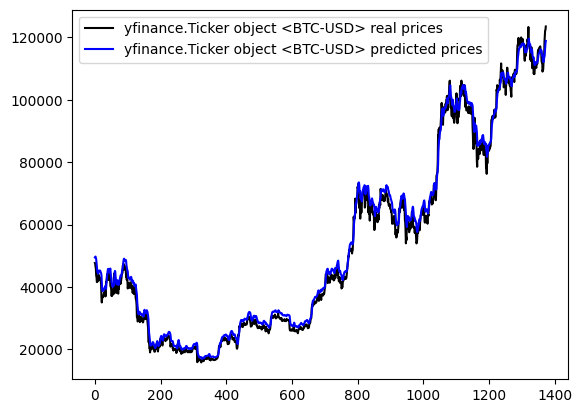

In [ ]:
plt.plot(actual_prices,color="black",label="BTC real prices")
plt.plot(predicted_prices,color="blue",label="BTC predicted prices")
plt.legend()
plt.show()

In [8]:
rentability = 1
for i in range(1,len(actual_prices)):
  if predicted_prices[i] > actual_prices[i-1]:
    rentability*= actual_prices[i]/actual_prices[i-1]

print((rentability-1)*100,"%")

211.72177596978705 %


In [9]:
directional_accuracy = np.mean(
    (np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
     np.sign(actual_prices[1:] - actual_prices[:-1]))
)
print("Precisión direccional:", directional_accuracy*100, "%")

Precisión direccional: 49.993236537128226 %


In [10]:
daily_return = (rentability ** (1/len(actual_prices))) - 1
print(daily_return * 100, "% por día")

0.08278103210226373 % por día
